# Dark Matter Representation

In this part, we will represent the Dark Matter. We use the dataset provided on https://drive.google.com/file/d/1IhgY91XCXz1QF5GoZow8Hu-YvzWbPZP6/view?usp=sharing, which is a set of simulated strong gravitational lensing images with and without substructure. We are going to use Convolution Neural Network (CNN) to learn the representation of dark matter in the strong gravitational lensing images provided using PyTorch. The goal is to use this learned representation for anomaly detection.

## Dataset

First, we need to split the dataset into training set and validation set. Here, I take the strategy of equality, that is to split images with and without substructure with same ratio (80% train, 20% valid). Of course you can have your customized converting ratio. If your download this repo directly, you will not split again for I have split them. If you want to re-split, just remove the `lenses-train` and `lenses-valid`. 

In [1]:
import os
import shutil

def split_files(src, train, valid, ratio=.8):
    
    # make directory everytime
    os.makedirs(src, exist_ok=True)
    os.makedirs(train, exist_ok=True)
    os.makedirs(valid, exist_ok=True)
    
    src_files = os.listdir(src)
    for idx, file_name in enumerate(src_files):
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
                if idx < len(src_files)*ratio:
                    shutil.copy(full_file_name, train)
                else:
                    shutil.copy(full_file_name, valid)
                    
# keep dir clean before copy files
sub_src = '../data/lenses/sub'
sub_train = '../data/lenses_train/sub'
sub_valid = '../data/lenses_valid/sub'
split_files(sub_src, sub_train, sub_valid, .8)

no_sub_src = '../data/lenses/no_sub'
no_sub_train = '../data/lenses_train/no_sub'
no_sub_valid = '../data/lenses_valid/no_sub'
split_files(no_sub_src, no_sub_train, no_sub_valid, .8)

Then we need to load the dataset. Instead of creating your customized `Dataset` class and `.csv` ground truth file, `torchvision` provides us a convenient method to load the dataset as follows. That's is also the reason why I designed the specific director paths above.

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose([
#         transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder(root='../data/lenses_train',
                                           transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

valid_dataset = datasets.ImageFolder(root='../data/lenses_valid',
                                           transform=data_transform)
valid_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

classes = ('no_sub', 'sub')

Let's see the first branch of our training set to get familiar!

<Figure size 576x576 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


     sub      sub      sub      sub      sub      sub   no_sub   no_sub


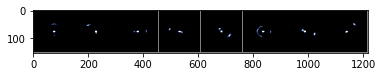

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    plt.figure(figsize=(8,8))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.show()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

After looking at this, you might realize that the challenge of this task. The naked eyes are basically unable to distinguish between the two classes, i.e., `sub` and `no_sub`. Let's see the magic of CNN!

## LensesCNN

Then, we use CNN to train lenses images and evaluate it on the validation set. We use `Relu` as our activation, and have 2 convolutional layers, pooling layers, and 3 full-connected layers. We use Cross Entropy Loss as our *Note that it's not a DEEP neural networks, but the result turns out to be not bad actually.*

Define CNN for lenses images.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 34 * 34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Select loss function and optimizer, set proper learning rate. 

In [6]:
import torch.optim as optim
import torch.optim.lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,\
#                                         steps_per_epoch=len(train_loader),\
#                                         epochs=3)

Train our model.

[1,   100] loss: 0.785
[1,   200] loss: 0.701
[1,   300] loss: 0.717
[1,   400] loss: 0.697
[1,   500] loss: 0.701
[1,   600] loss: 0.699
[1,   700] loss: 0.697
[1,   800] loss: 0.694
[1,   900] loss: 0.689
[1,  1000] loss: 0.668
[2,   100] loss: 0.631
[2,   200] loss: 0.639
[2,   300] loss: 0.644
[2,   400] loss: 0.611
[2,   500] loss: 0.623
[2,   600] loss: 0.564
[2,   700] loss: 0.545
[2,   800] loss: 0.488
[2,   900] loss: 0.484
[2,  1000] loss: 0.520
[3,   100] loss: 0.503
[3,   200] loss: 0.443
[3,   300] loss: 0.421
[3,   400] loss: 0.444
[3,   500] loss: 0.380
[3,   600] loss: 0.356
[3,   700] loss: 0.328
[3,   800] loss: 0.330
[3,   900] loss: 0.318
[3,  1000] loss: 0.396
[4,   100] loss: 0.286
[4,   200] loss: 0.279
[4,   300] loss: 0.307
[4,   400] loss: 0.275
[4,   500] loss: 0.263
[4,   600] loss: 0.264
[4,   700] loss: 0.250
[4,   800] loss: 0.247
[4,   900] loss: 0.340
[4,  1000] loss: 0.294
[5,   100] loss: 0.254
[5,   200] loss: 0.253
[5,   300] loss: 0.252
[5,   400] 

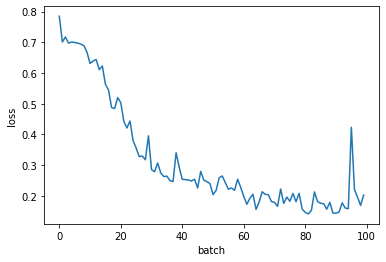

In [7]:
batch_loss = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/100))
            batch_loss.append(running_loss/100)
            running_loss = 0.0
            
#         scheduler.step()

plt.plot(batch_loss)
plt.xlabel('batch')
plt.ylabel('loss')
print('Finished Training')

The losses go down. Limited by GPU resources, we just train for 10 epochs. We save our model at `./lenses_net.pth`.

In [8]:
PATH = './lenses_net.pth'
torch.save(net.state_dict(), PATH)

Then it's time for validating our model. Let's see some images in validation set, and compare their ground truth value and prediction.

<Figure size 576x576 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  no_sub   sub no_sub no_sub   sub   sub no_sub no_sub
Predicted:  no_sub   sub no_sub no_sub   sub no_sub no_sub no_sub


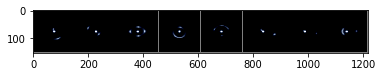

In [9]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

To evaluate our model, let's see the accuracy of the network on the test images. 

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 91 %


**91% correct!** Well done!

We also want to know the performance of `sub` and `no_sub` class respectively.

In [11]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of no_sub : 97 %
Accuracy of   sub : 85 %


In this training, result shows that the accuracy of recognizing `no_sub` is pretty high 97%, the accuray of sub is 85%. Note that this is not static, you will see different preformance if you re-train you model.

## Conclusion

In this notebook, we train our lenses neural networks by CNN, using dataset with lensing images with and without substructure. After ten epochs, the accuracy is as high as 91%, showing the effectiveness of our model.

In the future, we expect to use more NN modules on more thorough datasets, and figure out the most proper criteria, learning rate, optimizer, etc.